<a href="https://colab.research.google.com/github/vkthakur90/AI_Applications/blob/master/ARIMA_GARCH_on_Stock_Price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade arch

[*********************100%***********************]  1 of 1 completed


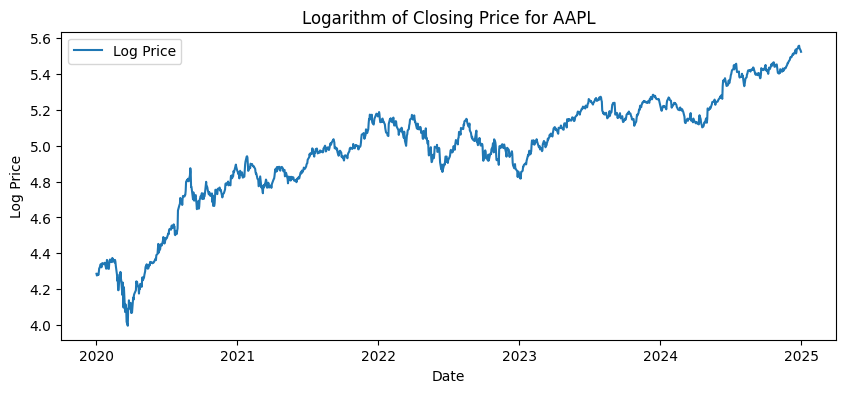

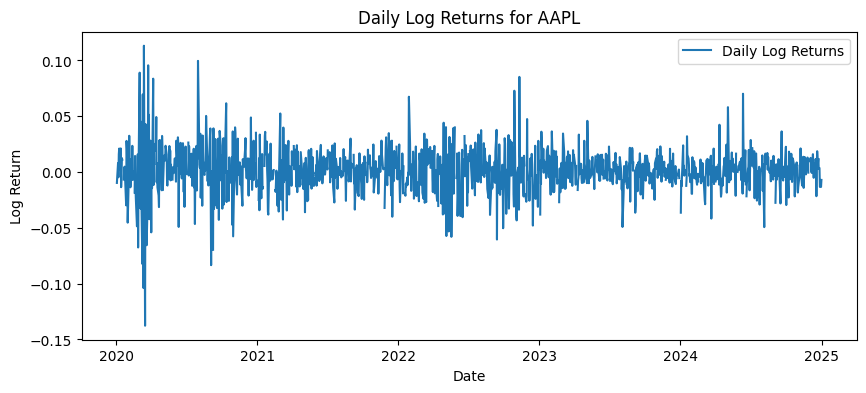

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:             Log_Return   No. Observations:                 1303
Model:                 ARIMA(5, 0, 5)   Log Likelihood                3163.035
Date:                Wed, 12 Feb 2025   AIC                          -6302.069
Time:                        11:30:33   BIC                          -6240.000
Sample:                    01-03-2020   HQIC                         -6278.783
                         - 12-31-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.001      1.900      0.057   -3.16e-05       0.002
ar.L1         -1.2271      2.954     -0.415      0.678      -7.016       4.562
ar.L2         -0.6422      4.182     -0.154      0.8

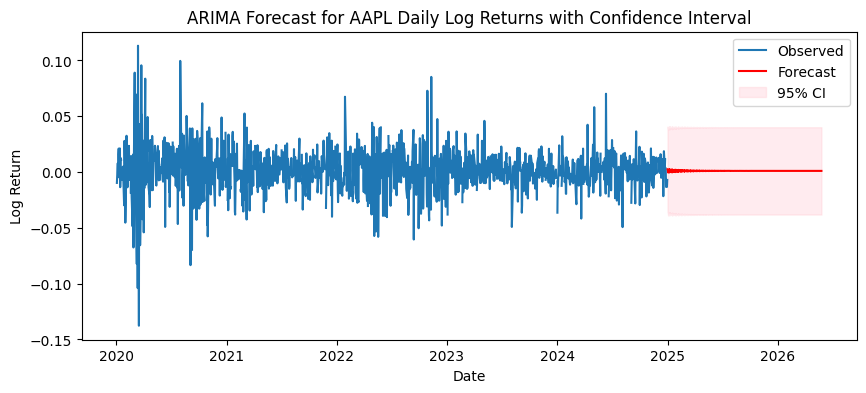

/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003818. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                3281.38
Distribution:                  Normal   AIC:                          -6538.76
Method:            Maximum Likelihood   BIC:                          -6477.12
                                        No. Observations:                 1257
Date:                Wed, Feb 12 2025   Df Residuals:                     1256
Time:                        11:30:35   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         3.5930e-04  4.881e-04      0.736      0.462 

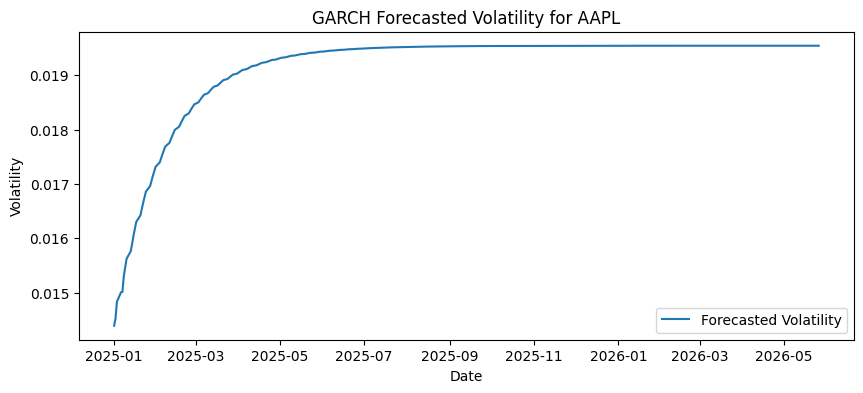

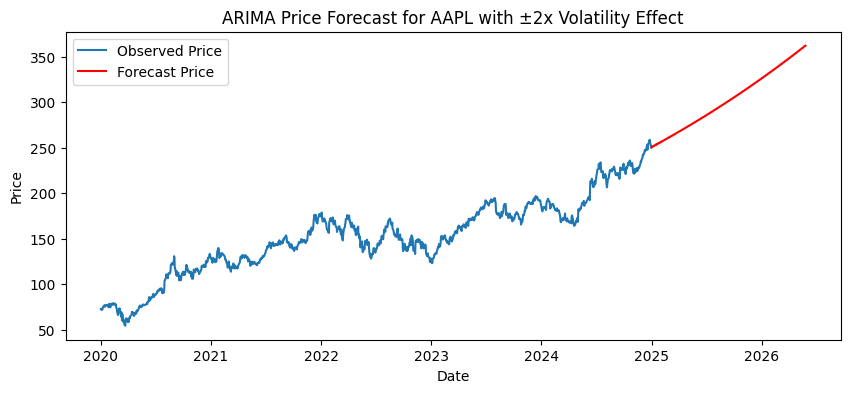

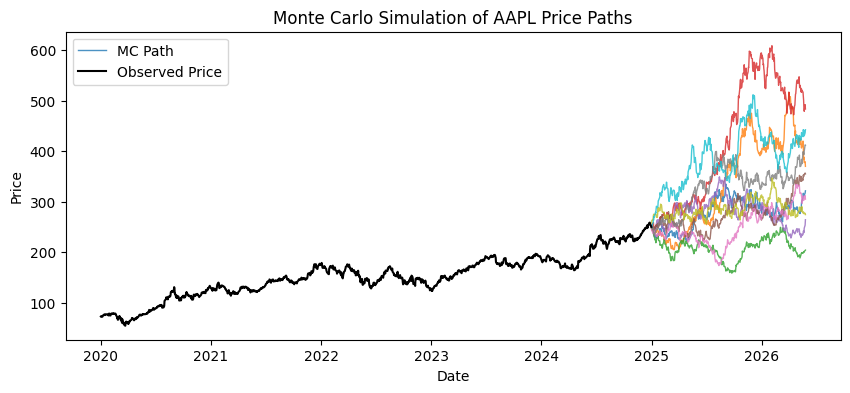

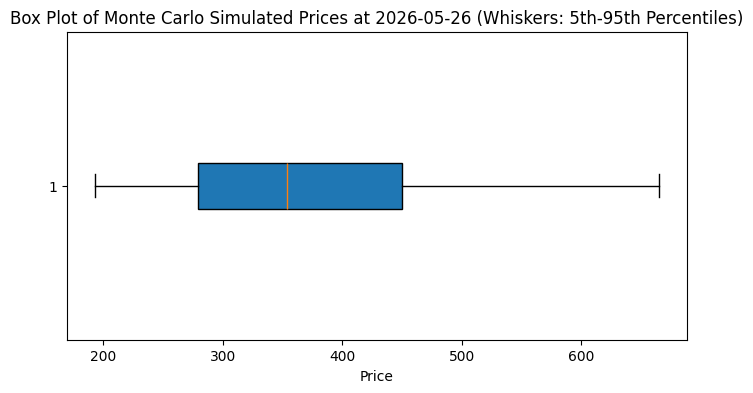

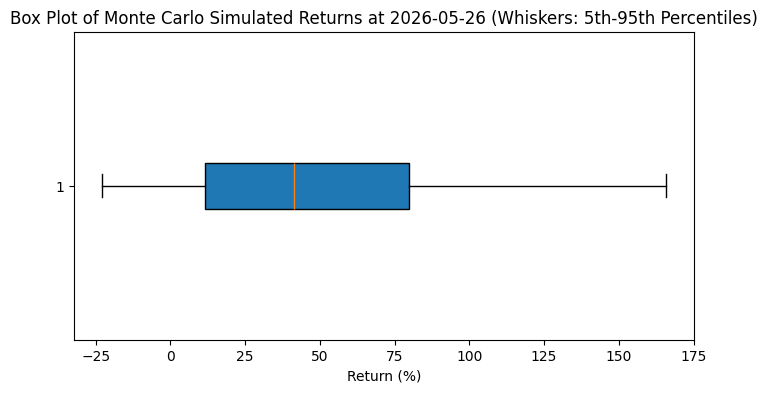

In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model  # Ensure you have installed the arch package (pip install arch)

# =============================================================================
# PARAMETERS (All parameters are defined at the beginning)
# =============================================================================

# Data parameters
ticker = 'AAPL'
start_date = '2020-01-01'
end_date = '2025-01-01'
frequency = 'B'  # Business day frequency

# ARIMA model parameters
arima_order = (5, 0, 5)  # (p, d, q) for ARIMA model

# Forecasting parameters
forecast_steps = 365  # Number of business days to forecast

# GARCH model parameters (applied to ARIMA residuals)
garch_p = 5  # GARCH order p
garch_q = 5  # GARCH order q
garch_distribution = 'normal'  # Distribution assumption for errors

# Monte Carlo simulation parameters
num_paths = 1000     # Number of Monte Carlo simulation paths to generate
paths_to_plot = 10   # Number of simulation paths to display in the plot

# =============================================================================
# DATA DOWNLOAD AND PREPARATION
# =============================================================================

# Download historical data
data = yf.download(ticker, start=start_date, end=end_date)

# Compute the logarithm of the closing price
data['Log_Price'] = np.log(data['Close'])

plt.figure(figsize=(10, 4))
plt.plot(data['Log_Price'], label='Log Price')
plt.title(f'Logarithm of Closing Price for {ticker}')
plt.xlabel('Date')
plt.ylabel('Log Price')
plt.legend()
plt.show()

# Calculate the daily log returns: log_return = log(Close_t / Close_{t-1})
data['Log_Return'] = np.log(data['Close'] / data['Close'].shift(1))
returns = data['Log_Return'].dropna()

# Ensure the index is a DateTimeIndex and set the frequency
returns.index = pd.to_datetime(returns.index)
returns = returns.asfreq(frequency)

plt.figure(figsize=(10, 4))
plt.plot(returns, label='Daily Log Returns')
plt.title(f'Daily Log Returns for {ticker}')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.legend()
plt.show()

# =============================================================================
# ARIMA MODELING AND FORECASTING OF LOG RETURNS (WITH CONFIDENCE INTERVAL)
# =============================================================================

# Fit the ARIMA model on the daily log returns
model = ARIMA(returns, order=arima_order)
model_fit = model.fit()
print(model_fit.summary())

# Forecast log returns using ARIMA
forecast_results = model_fit.get_forecast(steps=forecast_steps)
forecast_mean = forecast_results.predicted_mean
forecast_ci = forecast_results.conf_int()

# Create a date range for the forecast period and set it as the index
forecast_index = pd.date_range(start=returns.index[-1] + pd.Timedelta(days=1),
                               periods=forecast_steps, freq=frequency)
forecast_mean.index = forecast_index
forecast_ci.index = forecast_index

# Plot the ARIMA forecast of log returns with 95% confidence interval
plt.figure(figsize=(10, 4))
plt.plot(returns, label='Observed')
plt.plot(forecast_mean, label='Forecast', color='red')
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1],
                 color='pink', alpha=0.3, label='95% CI')
plt.title(f'ARIMA Forecast for {ticker} Daily Log Returns with Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.legend()
plt.show()

# =============================================================================
# GARCH ON ARIMA RESIDUALS
# =============================================================================

# Extract ARIMA model residuals and fit a GARCH(1,1) model
arima_resid = model_fit.resid.dropna()
garch_model = arch_model(arima_resid, vol='Garch', p=garch_p, q=garch_q, dist=garch_distribution)
garch_fit = garch_model.fit(disp='off')
print(garch_fit.summary())

# Forecast the conditional variance (volatility) for the next forecast_steps
garch_forecast = garch_fit.forecast(horizon=forecast_steps)
# Use the last available variance forecast from the in-sample period
forecast_variance = garch_forecast.variance.iloc[-1]
forecast_volatility = np.sqrt(forecast_variance)
forecast_volatility.index = forecast_index

plt.figure(figsize=(10, 4))
plt.plot(forecast_volatility, label='Forecasted Volatility')
plt.title(f'GARCH Forecasted Volatility for {ticker}')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()

# =============================================================================
# PRICE FORECAST FROM RETURN FORECAST WITH 2x VOLATILITY EFFECT
# =============================================================================

# Compute the price forecast from the forecasted log returns.
# Start with the last observed log price and add the cumulative sum of forecasted log returns.
last_log_price = data['Log_Price'].iloc[-1]
forecast_log_price = last_log_price + forecast_mean.cumsum()

# Instead of using the ARIMA confidence intervals, show the effect of ±2 times the volatility.
forecast_log_price_up = last_log_price + (forecast_mean + 2 * forecast_volatility).cumsum()
forecast_log_price_down = last_log_price + (forecast_mean - 2 * forecast_volatility).cumsum()

# Convert forecasted log prices back to the original price scale.
forecast_price = np.exp(forecast_log_price)
forecast_price_up = np.exp(forecast_log_price_up)
forecast_price_down = np.exp(forecast_log_price_down)

plt.figure(figsize=(10, 4))
plt.plot(data['Close'], label='Observed Price')
plt.plot(forecast_index, forecast_price, label='Forecast Price', color='red')
plt.title(f'ARIMA Price Forecast for {ticker} with ±2x Volatility Effect')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# =============================================================================
# MONTE CARLO SIMULATION OF PRICE PATHS
# =============================================================================

# Generate Monte Carlo simulation paths using the forecasted mean and volatility.
# For each forecast step, the simulated log return is:
#      simulated_return = forecast_mean[t] + forecast_volatility[t] * Z, where Z ~ N(0,1)
# The simulated log price is the cumulative sum of these returns, starting from the last observed log price.
simulated_paths = pd.DataFrame(index=forecast_index, columns=range(num_paths))

for path in range(num_paths):
    simulated_log_prices = []
    current_log_price = last_log_price
    for t in range(forecast_steps):
        mu = forecast_mean.iloc[t]
        sigma = forecast_volatility.iloc[t]
        # Draw a random shock from a standard normal distribution
        shock = mu + sigma * np.random.randn()
        current_log_price += shock
        simulated_log_prices.append(current_log_price)
    # Convert simulated log prices to prices and store in the DataFrame
    simulated_paths[path] = np.exp(simulated_log_prices)

# For plotting, randomly select a subset of simulation paths
np.random.seed(42)  # For reproducibility of the sample paths to plot
selected_paths = np.random.choice(simulated_paths.columns, paths_to_plot, replace=False)

plt.figure(figsize=(10, 4))
for path in selected_paths:
    plt.plot(simulated_paths.index, simulated_paths[path], lw=1, alpha=0.8,
             label='MC Path' if path == selected_paths[0] else None)
plt.plot(data['Close'], label='Observed Price', color='black')
plt.title(f'Monte Carlo Simulation of {ticker} Price Paths')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# =============================================================================
# BOX PLOT OF MONTE CARLO SIMULATED PRICES AT THE FORECAST HORIZON
# =============================================================================

# Extract the final simulated prices from the last forecast date
final_prices = simulated_paths.iloc[-1]

plt.figure(figsize=(8, 4))
# Set whis=(5,95) to use the 5th and 95th percentiles as the whisker boundaries,
# and set showfliers=False to not plot outliers.
plt.boxplot(final_prices, vert=False, patch_artist=True, whis=(5, 95), showfliers=False)
plt.xlabel('Price')
plt.title(f'Box Plot of Monte Carlo Simulated Prices at {forecast_index[-1].date()} (Whiskers: 5th-95th Percentiles)')
plt.show()

# =============================================================================
# BOX PLOT OF MONTE CARLO SIMULATED RETURNS AT THE FORECAST HORIZON
# =============================================================================

# Calculate the simulated returns as percentage change from the current (last observed) price.
current_price = data['Close'].iloc[-1].values[0]
simulated_returns = 100 * (final_prices - current_price) / current_price

plt.figure(figsize=(8, 4))
# Wrap the simulated returns in a list to produce a single box plot.
plt.boxplot(simulated_returns.values, vert=False, patch_artist=True, whis=(5, 95), showfliers=False)
plt.xlabel('Return (%)')
plt.title(f'Box Plot of Monte Carlo Simulated Returns at {forecast_index[-1].date()} (Whiskers: 5th-95th Percentiles)')
plt.show()
